In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:

from gensim.corpora.dictionary import Dictionary

In [5]:

import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize 


import pymorphy2 

In [6]:

stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 32.5 s


In [10]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 5min 5s


А теперь в 3 строчки обучим нашу модель

In [11]:
texts = [t for t in news['title'].values]

common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 4s


In [14]:
from gensim.test.utils import datapath
temp_file = datapath("model.lda")
lda.save(temp_file)

lda = LdaModel.load(temp_file)

In [15]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.02870514),
 (5, 0.023739608),
 (11, 0.35247216),
 (13, 0.4722003),
 (24, 0.10517004)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: ракета км ресторан горный таможенный маршрут граница
topic_1: год который это nn исследование человек млрд
topic_2: газета источник ru писать район это который
topic_3: погибнуть сотрудник эксперимент взрыв рак чиновник человек
topic_4: фотография ск конструкция дверь тепло следствие свердловский
topic_5: брат годовой год умереть выдать мышь жизнь
topic_6: nn миссия место катастрофа женщина рейтинг завод
topic_7: восток пострадать район поверхность восточный автомобиль адмирал
topic_8: население остров белый вицепремьер пресссекретарить снять песок
topic_9: земля мозг город который это москва также
topic_10: век армия русский высота отряд миллиард средний
topic_11: украина космос это кровь обращение год дональд
topic_12: метод испытание методика похоже негативно мастеркласс тест
topic_13: год млн рост стать составить доход возраст
topic_14: кремль тимур торжественно поновое кузьмин прибытие рот
topic_15: банк санкция граница год соглашение директор совет
topic_16: россия год э

In [17]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.064282,0.091546,0.000000,0.0,0.000000,0.03848,0.0,0.0,...,0.798012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,4896,0.000000,0.000000,0.129034,0.684113,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,4897,0.028707,0.000000,0.000000,0.000000,0.0,0.023653,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.105169
3,4898,0.000000,0.029545,0.162623,0.020744,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.594115,0.0,0.012895,0.000000
4,4899,0.000000,0.000000,0.000000,0.227941,0.0,0.000000,0.00000,0.0,0.0,...,0.595140,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [77]:
doc_dict[293622]

array([0.        , 0.33196887, 0.        , 0.        , 0.        ,
       0.03132116, 0.04421919, 0.        , 0.06108364, 0.        ,
       0.        , 0.0794901 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2710762 , 0.        ,
       0.        , 0.06327518, 0.        , 0.01691619, 0.09093644])

In [78]:
user_articles_list = users['articles'].iloc[33]

In [76]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [67]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [68]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [56]:
get_user_embedding(user_articles_list)

array([0.        , 0.13906746, 0.00536146, 0.08409911, 0.00802385,
       0.        , 0.        , 0.        , 0.02984946, 0.05057489,
       0.02028824, 0.00262431, 0.        , 0.03643582, 0.        ,
       0.01950644, 0.26133361, 0.        , 0.04877674, 0.00942607,
       0.12098594, 0.01544716, 0.        , 0.        , 0.13851023])

In [63]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.433694,0.033858,0.016591,0.000000,0.005220,0.010114,0.002413,0.040290,...,0.000000,0.096050,0.0,0.055502,0.0,0.024350,0.071199,0.000000,0.013264,0.039996
1,u108690,0.0,0.133705,0.062114,0.034875,0.000000,0.007242,0.007643,0.003806,0.021064,...,0.026265,0.261597,0.0,0.082830,0.0,0.102922,0.013552,0.005342,0.000000,0.083435
2,u108339,0.0,0.207134,0.034658,0.133289,0.009785,0.006080,0.008595,0.008003,0.011411,...,0.016267,0.236448,0.0,0.013271,0.0,0.035404,0.049698,0.000000,0.000000,0.106371


In [64]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.328402,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.027067,...,0.000000,0.057335,0.0,0.000000,0.0,0.000000,0.057869,0.0,0.0,0.00000
1,u108690,0.0,0.067404,0.029318,0.00000,0.000000,0.0,0.0,0.000000,0.009006,...,0.017446,0.189047,0.0,0.053968,0.0,0.092107,0.008689,0.0,0.0,0.02924
2,u108339,0.0,0.229924,0.028252,0.10992,0.005566,0.0,0.0,0.006287,0.005029,...,0.000000,0.155814,0.0,0.011941,0.0,0.026814,0.028041,0.0,0.0,0.12100


In [69]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.775908,0.146691,0.099547,0.000000,0.031321,0.044219,0.014478,0.126519,...,0.000000,0.240414,0.0,0.271076,0.0,0.146099,0.195389,0.000000,0.062671,0.149043
1,u108690,0.0,0.353529,0.206226,0.179295,0.000000,0.030652,0.035383,0.022836,0.089229,...,0.069749,0.595689,0.0,0.224888,0.0,0.225733,0.041926,0.021917,0.000000,0.268612
2,u108339,0.0,0.340088,0.070981,0.278662,0.028862,0.023982,0.035986,0.020150,0.041701,...,0.056775,0.525188,0.0,0.028502,0.0,0.090530,0.153297,0.000000,0.000000,0.217630


In [70]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [72]:
X1 = pd.merge(user_embeddings_mean, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.433694,0.033858,0.016591,0.000000,0.005220,0.010114,0.002413,0.040290,...,0.096050,0.0,0.055502,0.0,0.024350,0.071199,0.000000,0.013264,0.039996,0
1,u108690,0.0,0.133705,0.062114,0.034875,0.000000,0.007242,0.007643,0.003806,0.021064,...,0.261597,0.0,0.082830,0.0,0.102922,0.013552,0.005342,0.000000,0.083435,1
2,u108339,0.0,0.207134,0.034658,0.133289,0.009785,0.006080,0.008595,0.008003,0.011411,...,0.236448,0.0,0.013271,0.0,0.035404,0.049698,0.000000,0.000000,0.106371,1


In [73]:
X2 = pd.merge(user_embeddings_median, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.328402,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.027067,...,0.057335,0.0,0.000000,0.0,0.000000,0.057869,0.0,0.0,0.00000,0
1,u108690,0.0,0.067404,0.029318,0.00000,0.000000,0.0,0.0,0.000000,0.009006,...,0.189047,0.0,0.053968,0.0,0.092107,0.008689,0.0,0.0,0.02924,1
2,u108339,0.0,0.229924,0.028252,0.10992,0.005566,0.0,0.0,0.006287,0.005029,...,0.155814,0.0,0.011941,0.0,0.026814,0.028041,0.0,0.0,0.12100,1


In [74]:
X3 = pd.merge(user_embeddings_max, target, 'left')
X3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.775908,0.146691,0.099547,0.000000,0.031321,0.044219,0.014478,0.126519,...,0.240414,0.0,0.271076,0.0,0.146099,0.195389,0.000000,0.062671,0.149043,0
1,u108690,0.0,0.353529,0.206226,0.179295,0.000000,0.030652,0.035383,0.022836,0.089229,...,0.595689,0.0,0.224888,0.0,0.225733,0.041926,0.021917,0.000000,0.268612,1
2,u108339,0.0,0.340088,0.070981,0.278662,0.028862,0.023982,0.035986,0.020150,0.041701,...,0.525188,0.0,0.028502,0.0,0.090530,0.153297,0.000000,0.000000,0.217630,1


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

# Learn

In [43]:
def learning(X):
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'], random_state=0)
    logreg = LogisticRegression()
    #обучим 
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    return preds

In [79]:
preds_mean = learning(X1)
preds_median = learning(X2)
preds_max = learning(X3)

In [45]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [80]:
def find_metrics(preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    return precision, recall, thresholds, fscore, ix

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [84]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
def plot_Matrix(preds, thresholds, ix):

    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

Confusion matrix, without normalization
[[1612  143]
 [  50  195]]


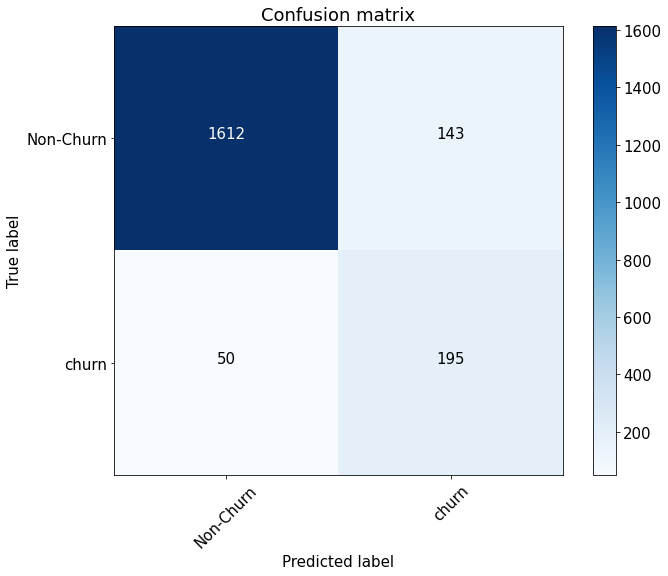

In [105]:
precision_mean, recall_mean, thresholds_mean, fscore_mean, ix_mean = find_metrics(preds_mean)
plot_Matrix(preds_mean, thresholds_mean, ix_mean)

Confusion matrix, without normalization
[[1691   64]
 [  46  199]]


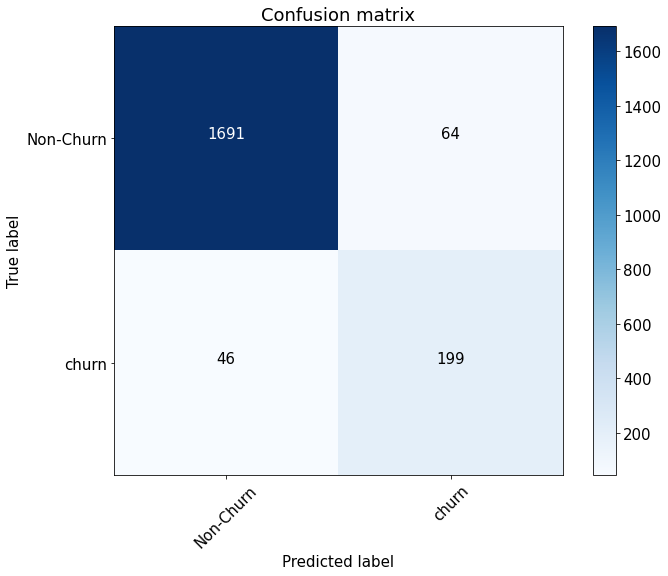

In [90]:
precision_median, recall_median, thresholds_median, fscore_median, ix_median = find_metrics(preds_median)
plot_Matrix(preds_median, thresholds_median, ix_median)

Confusion matrix, without normalization
[[1684   71]
 [  65  180]]


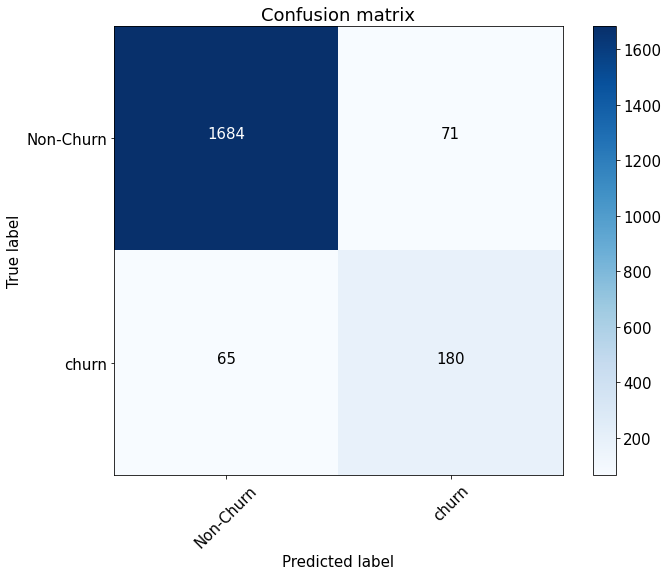

In [91]:
precision_max, recall_max, thresholds_max, fscore_max, ix_max = find_metrics(preds_max)
plot_Matrix(preds_max, thresholds_max, ix_max)

In [98]:
roc_auc_mean = roc_auc_score(y_test, preds_mean)
roc_auc_mean

0.9464503750218035

In [102]:
roc_auc_median = roc_auc_score(y_test, preds_median)
roc_auc_median

0.9742915285772429

In [107]:
roc_auc_max = roc_auc_score(y_test, preds_max)
roc_auc_max

0.956578870864585

In [111]:
tabledata = [["Embeddings mean", roc_auc_mean, precision_mean, recall_mean, fscore_mean],
             ["Embeddings median", roc_auc_median, precision_median, recall_median, fscore_median],
             ["Embeddings max", roc_auc_max, precision_max, recall_max, fscore_max]]


In [112]:
pd.DataFrame(tabledata, columns=["Embeddings type","roc_auc", "precision", "recall", "fscore"])

,Embeddings type,roc_auc,precision,recall,fscore
0,Embeddings mean,0.946450,"[0.23603082851637766, 0.23529411764705882, 0.2...","[1.0, 0.9959183673469387, 0.9959183673469387, ...","[0.3819173811379579, 0.38065522620904835, 0.38..."
1,Embeddings median,0.974292,"[0.330188679245283, 0.3292847503373819, 0.3297...","[1.0, 0.9959183673469387, 0.9959183673469387, ...","[0.4964539007092198, 0.4949290060851927, 0.495..."
2,Embeddings max,0.956579,"[0.1912568306010929, 0.190625, 0.1907740422204...","[1.0, 0.9959183673469387, 0.9959183673469387, ...","[0.3211009174311926, 0.31999999999999995, 0.32..."
